In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
from scipy.integrate import odeint

import os
from netCDF4 import Dataset
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D


In [3]:
# Import and apply style file for plots
plt.style.use("mpl.style")
%matplotlib inline

### Table of Contents

* [Functions](#Functions)
    * [General](#general)
        * [File Handling](#file_handling)
        * [Extract LAMMPS Data](#extract_LAMMPS_data)
        * [Plotting](#plotting)
* [Test Cases](#test_cases)
    * [Taylor-Green Vortex](#TG_funcs)
    * [Poiseuille Flow](#PF_funcs)
    * [Extended Droplet](#ED_funcs)
    * [Kernel Convergence - Velocity Gradient](#gradv_funcs)
    * [Kernel Convergence - Surface Normals](#surf_funcs)

# Functions <a class="anchor" id="Functions"></a>


## General <a class="anchor" id="general"></a>

### File Handling <a class="anchor" id="file_handling"></a>

Files will follow the common naming convention: a_b_c_comments.nc
* a is flexible and can denote shifting on/off, verlet integrator type, fluid model, etc. The meaning of a is specified on a case by case basis
* b is the kernel type: Quintic = 5, CRK0 =0, CRK1 = 1, CRK2 = 2
* c is the scale factor (sf the lammps script)
* comments is any additional descriptors for the run, but will not appear on the plot or in the labels

In [4]:
#Compile all filenames in a given directory into a dictionary
#value=filepath, key = run properties
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

#Collect run info from a file name
def parse_file_name(run_file):
    run_info = list(run_file)[0:2]
    #keep var_0 as numeric (so it's generic), only replace with string for labels
    #run_info[0]=var_0_key[var_0]
    run_info[1]=var_1_key[run_info[1]]
    
    return run_info

#Extract and calculate variables dependent on scale factor sf
def scaling_vars(run):
    sf = 1/int(list(run)[2]) #Scaling of unit cell
    L_z = h3*(d-2)*sf #Account for L_z if d=3
    n = 1/sf**d #Number density - number of particles per volume
    mp = rho0/n #Mass of particles (density is constant)
    if d == 3:
        N = R*R*L_z/sf**d # Total number of atoms
    elif d == 2:
        N = R*R/sf**d 
    return sf, mp, N

def gather_run_info(run,data_files):
    
    run_info = parse_file_name(run)
    ds = Dataset(data_files[run])
    sf, mp, N = scaling_vars(run)
    run_info.append(sf)

    return run_info, ds, sf, mp, N

### LAMMPS Data <a class="anchor" id="extract_LAMMPS_data"></a>

In [5]:
#Returns coordinates and velocities for all particles at each timestep
def extract_velocity_data(ds):
    td = ds["time"][:]
    xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
    yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
    vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
    vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
    return td,xd,yd,vxd,vyd

def calc_KE(td,xd,yd,vxd,vyd,mp):
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd
    return E_tot
    

### Plotting <a class="anchor" id="plotting"></a>

In [6]:
#Plot types

#Normalized Error Plot#
#Input is a dataframe with columns ["shifting","CRK","sf","L1 norm"]
#L1 will vary, e.g. viscosity, surface normal, velocity gradient, etc.
def plot_normalized_error(all_run_info):
    df = pd.DataFrame(all_run_info, columns=["var0","CRK","sf","Surf Normal Normalized Error"])    
    #df.sort_values(by=["sf","CRK"], inplace=True)
    df.sort_values(by=["sf"], inplace=True)
    L1_label = df.iloc[:,-1:].columns[0]
    for i in df["var0"].unique():
        df_1 = df[df["var0"]==i]
        for j in df_1["CRK"].unique():
            df_2 = df_1[df_1["CRK"]==j]
            df_2 = df_2.sort_values(by=["sf"])
            label = j
            plt.loglog(R/df_2["sf"],df_2[L1_label],
                       marker=plot_key[j][0],
                       linestyle=plot_key[i],
                       markerfacecolor="None",
                       color=plot_key[j][1],
                       label=label)
            #print(df_2)
            

#Generic y vs x profile (e.g. velocity vs time)        
def plot_profile(x,y,run_info, ax, plot_type, plot_key):
    ax = ax
    if plot_type == "data":
        ax.plot(x, y,
                        linestyle=plot_key[run_info[0]],
                        marker=plot_key[run_info[1]][0],
                        markevery=0.2,
                        markerfacecolor="None",
                        color=plot_key[run_info[1]][1],
                        label = run_info[1])
    if plot_type == "analytic":
        ax.plot(x, y,
                   label = "Analytic",
                   color="red",
                   linestyle="solid")

In [7]:
#Plot formatting

#Retrieve the default labels and handles
def order_labels(ax):
    label_order_dict = {"Quintic":0,"CRK0":1,"CRK1":2,"CRK2":3,"Analytic":4,"other":5}
    handles,labels = ax.get_legend_handles_labels()
    label_order_unsorted = []
    labels_sorted = []
    for label in labels:
        if label in label_order_dict:
            label_order_unsorted.append([label_order_dict[label],label])
        else:
            label_order_unsorted.append([label_order_dict["other"],label])
    label_order_sorted = sorted(label_order_unsorted)
    for label in label_order_sorted:
        labels_sorted.append(label[1])

    handle_dict = dict(zip(labels,handles))
    handles_sorted = []
    for i in labels_sorted:
        handles_sorted.append(handle_dict[i])
    
    return handles_sorted, labels_sorted

#Generate custom plot handles for the given labels
def generate_handles(ax):
    handles,labels = order_labels(ax)
    labels_unique = [x for i, x in enumerate(labels) if labels.index(x) == i]
    custom_handles = []
    for label in labels_unique:
        custom_handles.append(Line2D((0,1), (0,0), color=plot_key[label][1], marker=plot_key[label][0], markerfacecolor="None", label=label))
    for i in var_0_key:
        custom_handles.append(Line2D((0,1), (0,0), color="black", linestyle=plot_key[i],  markerfacecolor="None",label=var_0_key[i]))
    return custom_handles
        

#Manually change the plot format to suit the data
def format_plot(fig, ax, plot_params):
    for i, ax in enumerate(fig.axes):
        #Axis labels and limits
        x_lab,y_lab,x_lim,y_lim,legend_loc = plot_params[i]
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        #Legend
        handles = generate_handles(ax)
        ax.legend(handles=handles, loc=legend_loc)
    if type(ax)=='numpy.ndarray':
        plt.tight_layout()

# Test Cases <a class="anchor" id="test_cases"></a>

In [7]:
#Global keys
var_1_key = {"5":"Quintic","0":"CRK0", "1":"CRK1", "2":"CRK2"}

plot_key = {"Quintic":["o","#5ec962"],"CRK0":["X","#21918c"], "CRK1":["s","#3b528b"],"CRK2":["d","#440154"],
            "Analytic":["","red"],"0":"dashed","1":"dotted"} #Viridis colors

#plot_key_1 = {"Quintic":["o","#0d0887"],"CRK0":["X","#7e03a8"], "CRK1":["s","#7e03a8"],"CRK2":["d","#f89540"]} #Warm colors


## Taylor-Green Vortex <a class="anchor" id="TG_funcs"></a>

In [8]:
#Analytical velocity profile
def vel_x_y_t(x,y,t,k_x,k_y,tau):
    u_x = -u_0*np.cos(k_x*x)*np.sin(k_y*y)
    u_y = u_0*np.sin(k_x*x)*np.cos(k_y*y)
    u_t = np.exp(-t/tau)
    return np.sum(np.abs(u_x), axis=1)*u_t , np.sum(np.abs(u_y), axis=1)*u_t

#Pressure decay profile
def calc_rho_max_ref(td,xd,yd,vxd,vyd):
    cs = 4.0
    v0 = np.sqrt(xd**2+yd**2)[0]
    F_t = np.exp(-2*nu*td)
    rho_max = rho0+np.max(v0**2*rho0/cs**2/4*(np.cos(2*k_x*xd)+np.cos(2*k_y*yd)),axis=1)*F_t**2

    return rho_max
    

#Calculate actual and theoretical kinetic energy given coordinate and velocity data
def calc_TG_KE(td,xd,yd,vxd,vyd,mp):
    #Actual
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd
    #Analytic
    ref_vx, ref_vy = vel_x_y_t(xd,yd,td,k_x,k_y,tau) #Total velocity magnitude in x,y
    ref_Ex = 0.5*mp*(ref_vx)**2
    ref_Ey = 0.5*mp*(ref_vy)**2
    ref_E_tot = (ref_Ex + ref_Ey)
    
    return td, E_tot, ref_E_tot

def calc_viscosity_error(td, E_tot, ref_E_tot):
    
    #Viscosity calculation from slope of semilogy(E_tot vs t)
    slope_d = linregress(td, np.log(E_tot/E_tot[0]))[0]
    nu_d = -slope_d/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data
        
    #Viscosity calculation from analytical solution
    slope_ref = linregress(td, np.log(ref_E_tot/ref_E_tot[0]))[0]
    nu_ref = -slope_ref/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data

    #Error
    nu_error = np.abs(nu_ref-nu_d)
    
    return nu_error

### Test Case 1
Compares the performance of all kernel types when shifting is turned on and off. Ran with rlammps_rho_evol

FileNotFoundError: [Errno 2] No such file or directory: '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/old_data_files/rho_evol/data_files'

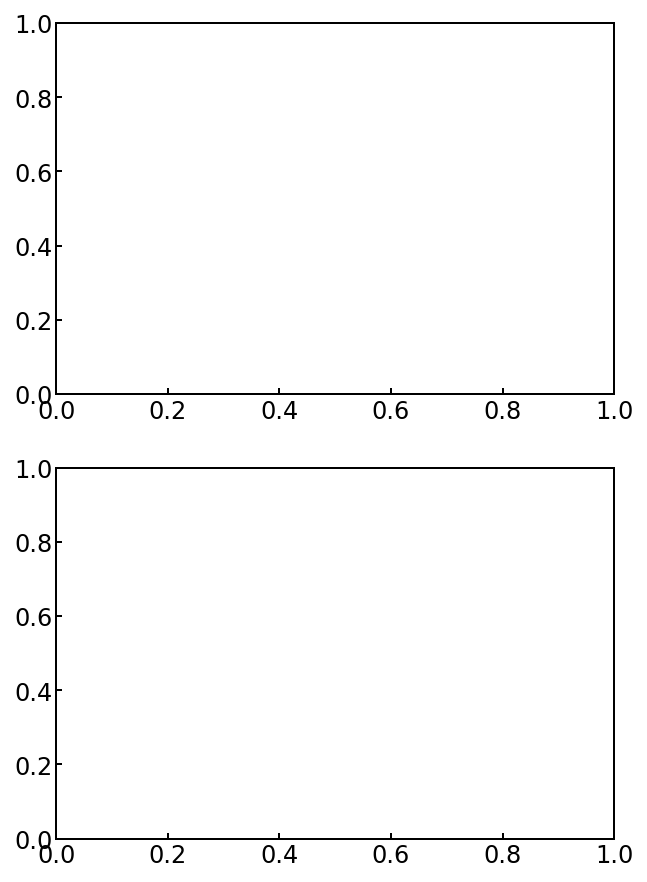

In [9]:
#################################
# Test-specific keys
#################################
var_0_key = {"0":"Shifting Off","1":"Shifting On"} #Viscosity calc method
plot_key["Slope = -4"]=["","red"]

#################################
# Simulation parameters
#################################
d = 2 #dimensions
h3 = 3.5 #smoothing length coefficient
R = 10 #system size

rho0 = 1 #density
eta = 0.1 # dynamic viscosity
nu = eta/rho0 #kinematic viscosity

u_0 = 0.1 #velocity scale
k_x = 2*np.pi/R #periodicity in x
k_y = k_x #periodicity in y
tau = 1/nu/(k_x**2+k_y**2) #decay timescale

#################################
# Plot parameters
#################################
fig, ax = plt.subplots(2,1,figsize=(10,15))

#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/old_data_files/rho_evol/data_files'
data_files = generate_file_names(filepath)

all_run_info = []

for run in data_files:
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)

    #Extract position and velocity data from ds
    td,xd,yd,vxd,vyd = extract_velocity_data(ds)

    #Calculate KE from velocity data
    td, E_tot, ref_E_tot = calc_TG_KE(td,xd,yd,vxd,vyd,mp)

    #Plot KE (select only a specific sf to plot)
    if sf == 0.2:
        plot_profile(td*u_0/R, E_tot/E_tot[0], run_info, ax[0], "data",plot_key)

    #Calculate viscosity error
    nu_L1_norm = calc_viscosity_error(td, E_tot, ref_E_tot)/N
    run_info.append(nu_L1_norm)

    all_run_info.append(run_info)

#Plot one analytical energy profile on top of all runs
plot_profile(td*u_0/R, ref_E_tot/ref_E_tot[0], run_info, ax[0],"analytic",plot_key)

#Viscosity error plot
plot_normalized_error(all_run_info)

#Reference line for viscosity error plot
y_ref = [10e-5,10e-9]
x_ref = [20,200]
ax[1].loglog(x_ref,y_ref, 
             color="red",
             linestyle="solid",
             label="Slope = -4")

#################################
# Plot format
#################################
KE_plot_params = [r"$\frac{tu_0}{L}$",r"$\frac{E_k}{E_{k0}}$",
                  [0,0.3],[1e-3,1],
                  "lower left"]
nu_plot_params = [r"$\frac{L}{\Delta x}$",r"$\frac{L_1}{N}$",
                  [10**0.9,10**2.5],None,
                  "lower left"]
format_plot(fig, ax,[KE_plot_params,nu_plot_params])

#log y scale for kinetic energy plots
ax[0].set_yscale("log")


### Test Case 2

Compares the performance of all kernel types when between two versions of the verlet integrator. In the file naming convention a_b_c_comments.nc, a=0 for the standard verlet integrator and a=1 for the updated verlet integrator from the Adami 2012 paper. Shifting is turned off for all runs.

In [ ]:
#################################
# Test-specific keys
#################################
var_0_key = {"0":"Standard Verlet","1":"Updated Verlet"} #Viscosity calc method

#################################
# Simulation parameters
#################################
d = 2 #dimensions
h3 = 3.5 #smoothing length coefficient
R = 10 #system size

rho0 = 1 #density
eta = 0.1 # dynamic viscosity
nu = eta/rho0 #kinematic viscosity

u_0 = 0.1 #velocity scale
k_x = 2*np.pi/R #periodicity in x
k_y = k_x #periodicity in y
tau = 1/nu/(k_x**2+k_y**2) #decay timescale

#################################
# Plot parameters
#################################

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/updated_verlet_reduced_eta/ncdf/'

all_run_info = []
data_files = generate_file_names(filepath)
for run in data_files:
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    td,xd,yd,vxd,vyd = extract_velocity_data(ds)
    rho_max_ref = calc_rho_max_ref(td,xd,yd,vxd,vyd)
    if sf == 0.1:
        rho_max = np.max(ds["c_den"],axis=1)
        td = ds["time"][:]
        plot_profile(td*u_0/R, rho_max, run_info, ax, "data",plot_key)

#plot_profile(td*u_0/R, rho_max_ref, run_info, ax,"analytic",plot_key)


#################################
# Plot format
#################################
rho_plot_params = [r"$\frac{tu_0}{L}$",r"$\rho$",
                  [None,None],[None,None],
                  "upper right"]

format_plot(fig, ax,[rho_plot_params])


### Test Case 3:

Iteration of test case 2, except shifting is turned off for all runs. In the file naming convention a_b_c_comments.nc, a=0 for the standard verlet integrator and a=1 for the updated verlet integrator from the Adami 2012 paper.

In [ ]:
#################################
# Test-specific keys
#################################

#Same as before

#################################
# Simulation parameters
#################################

#Same as before

#################################
# Plot parameters
#################################

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_axes([0,0,1,1])


#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/updated_verlet_reduced_eta_noshift/ncdf/'

all_run_info = []
data_files = generate_file_names(filepath)
for run in data_files:
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    if sf == 0.1:
        rho_max = np.max(ds["c_den"],axis=1)
        td = ds["time"][:]
        plot_profile(td*u_0/R, rho_max, run_info, ax, "data",plot_key)

#################################
# Plot format
#################################
rho_plot_params = [r"$\frac{tu_0}{L}$",r"$\rho$",
                  [None,None],[None,None],
                  "upper left"]

format_plot(fig, ax,[rho_plot_params])

### Test Case 4
Iteration of test case 1, with shifting turned on and density diffusion parameter Dr reduced from 0.05 to 0.005. In the file naming convention a_b_c_comments.nc, a=0 for the standard verlet integrator and a=1 for the updated verlet integrator from the Adami 2012 paper. Note: this simulation doesn't run stably if shifting is turned off

In [ ]:
#################################
# Test-specific keys
#################################

#Same as before

#################################
# Simulation parameters
#################################

#Same as before

#################################
# Plot parameters
#################################

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_axes([0,0,1,1])


#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/updated_verlet_reducedeta_noshift_reducedDr/ncdf/'

all_run_info = []
data_files = generate_file_names(filepath)
for run in data_files:
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    if sf == 0.1:
        rho_max = np.max(ds["c_den"],axis=1)
        td = ds["time"][:]
        plot_profile(td*u_0/R, rho_max, run_info, ax, "data",plot_key)

#################################
# Plot format
#################################
rho_plot_params = [r"$\frac{tu_0}{L}$",r"$\rho$",
                  [None,None],[None,None],
                  "upper right"]

format_plot(fig, ax,[rho_plot_params])

## Poiseuille Flow <a class="anchor" id="PF_funcs"></a>

In [ ]:
#Analytical solution for Newtonian Poiseuille Flow in 2D rectangular channel 
def poiseuille_analyt(r,t,model):
    P_grad = -f_ext
    if model == "Newtonian":
        u_z = 0.5/eta*(-P_grad)*(R**2-r**2)
    elif model == "Power Law":
        u_z = npow/((2*k)**(1/npow)*(npow+1))*(-P_grad)**(1/npow)*(R**(1/npow+1)-(np.abs(r))**(1/npow+1))        
    return u_z

def poiseuille_data(run, ds):
    #list of all atoms
    atom_ids = ds["id"][frame]
    #list of flow atoms
    flow_atom_ids = []

    #iterate over each atom
    for count, atom in enumerate(atom_ids):
        if ds["type"][int(frame),int(atom)-1]==1:
            flow_atom_ids.append(atom)


    t_frame = ds["time"][frame]

    u_z = np.zeros(shape=len(flow_atom_ids))
    r = np.zeros(shape=len(flow_atom_ids))
    for count, atom in enumerate(flow_atom_ids):
        r[count] = ds["coordinates"][frame,atom-1,1]
        u_z[count] = ds["velocities"][frame,atom-1,0]
    
    return t_frame, r, u_z

    
def poiseuille_benchmark(data_files, ax):
    ax = ax
    for run in data_files:
        #Gather run info from the file name
        run_info, ds, sf, mp, N = gather_run_info(run,data_files)
        model = run_info[0]
        
        #Data velocity profile
        t_frame, r, u_z = poiseuille_data(run, ds)
        r_norm = r/R
        u_z_norm = u_z/np.max(u_z)
        #Reformat the data for plotting
        u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
        u_prof = u_prof[u_prof[:,0].argsort()]
        #Only need R>0 because the data is symmetrical
        u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]
        
        #Plot data for each run
        if model == "0":
            plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[0],"data",plot_key)
        elif model == "1":
            plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[1], "data",plot_key)

            
    
    #Plot analytic solution over all runs
    models = ["Newtonian", "Power Law"]
    for count, model in enumerate(models):
        #Calculate analytic velocity profile
        r_ref = np.linspace(0,R,25)
        u_z_ref = poiseuille_analyt(r_ref, t_frame, model)

        r_ref_norm = r_ref/R
        u_z_ref_norm = u_z_ref/np.max(u_z_ref)
        
        u_prof_analyt = np.hstack((r_ref_norm[:,None],u_z_ref_norm[:,None]))
        u_prof_analyt = u_prof_analyt[u_prof_analyt[:,0].argsort()] 
        
        #Plot
        plot_profile(u_prof_analyt[:,0],u_prof_analyt[:,1],run_info, ax[count], "analytic",plot_key)
        


Test case 1: baseline test with same parameters as the TG vortex runs

In [ ]:
#################################
# Test-specific keys
#################################
var_0_key = {"0":"Newtonian","1":"Power Law"} #Viscosity calc method

#################################
# Simulation parameters
#################################
#System dimensions
outer_R = 10
R = 6.99
d = 3 #3d

#Smoothing length coefficient
h3 = 3.5

#Fluid properties
eta = 1000
rho0 = 1
nu = eta/rho0
gd0 = 1e-2
npow=0.5
k = eta*gd0**(1-npow)

#Scaling parameters
sf = 0.2
nb =1
n = nb/sf**2

L_z = h3*(d-2)*sf #Account for L_z if d=3
n = 1/sf**d #Number density - number of particles per volume
mp = rho0/n #Mass of particles (density is constant)

#External Force
f_ext = 1e-3
frame = -1

#################################
# Plot parameters
#################################
fig, ax = plt.subplots(2,1,figsize=(10,15))


#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/poiseuille_flow/wall_debug_03_02/ncdf/'
data_files = generate_file_names(filepath)

for run in data_files:
    #Gather run info from the file name
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    model = run_info[0]

    #Data velocity profile
    t_frame, r, u_z = poiseuille_data(run, ds)
    r_norm = r/R
    u_z_norm = u_z/np.max(u_z)
    #Reformat the data for plotting
    u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]
    #Only need R>0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]

    #Plot data for each run
    if model == "0":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[0],"data",plot_key)
    elif model == "1":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[1], "data",plot_key)



#Plot analytic solution over all runs
models = ["Newtonian", "Power Law"]
for count, model in enumerate(models):
    #Calculate analytic velocity profile
    r_ref = np.linspace(0,R,25)
    u_z_ref = poiseuille_analyt(r_ref, t_frame, model)

    r_ref_norm = r_ref/R
    u_z_ref_norm = u_z_ref/np.max(u_z_ref)

    u_prof_analyt = np.hstack((r_ref_norm[:,None],u_z_ref_norm[:,None]))
    u_prof_analyt = u_prof_analyt[u_prof_analyt[:,0].argsort()] 

    #Plot
    plot_profile(u_prof_analyt[:,0],u_prof_analyt[:,1],run_info, ax[count], "analytic",plot_key)

#################################
# Plot format
#################################
###Plot Format###
Newtonian_plot_params = [r"$\frac{r}{R}$",r"$\frac{u}{u_{max}}$",
                  None,None,
                  "lower left"]
Power_plot_params = Newtonian_plot_params
format_plot(fig, ax,[Newtonian_plot_params,Power_plot_params])

Test case 2: CRK2 was unstable for both power law and Newtonian fluids, so viscosity and external force were reduced to create a more mild physical system

In [ ]:
#Smoothing length coefficient
h3 = 3.5

#Fluid properties
eta = 0.01
rho0 = 1
nu = eta/rho0
gd0 = 1e-2
npow=0.5
k = eta*gd0**(1-npow)

#External Force
f_ext = 1e-5
frame = -1

#################################
# Plot parameters
#################################
fig, ax = plt.subplots(2,1,figsize=(10,15))

#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/poiseuille_flow/wall_debug_red_eta_fext/ncdf/'
data_files = generate_file_names(filepath)

for run in data_files:
    #Gather run info from the file name
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    model = run_info[0]

    #Data velocity profile
    t_frame, r, u_z = poiseuille_data(run, ds)
    r_norm = r/R
    u_z_norm = u_z/np.max(u_z)
    #Reformat the data for plotting
    u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]
    #Only need R>0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]

    #Plot data for each run
    if model == "0":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[0],"data",plot_key)
    elif model == "1":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[1], "data",plot_key)



#Plot analytic solution over all runs
models = ["Newtonian", "Power Law"]
for count, model in enumerate(models):
    #Calculate analytic velocity profile
    r_ref = np.linspace(0,R,25)
    u_z_ref = poiseuille_analyt(r_ref, t_frame, model)

    r_ref_norm = r_ref/R
    u_z_ref_norm = u_z_ref/np.max(u_z_ref)

    u_prof_analyt = np.hstack((r_ref_norm[:,None],u_z_ref_norm[:,None]))
    u_prof_analyt = u_prof_analyt[u_prof_analyt[:,0].argsort()] 

    #Plot
    plot_profile(u_prof_analyt[:,0],u_prof_analyt[:,1],run_info, ax[count], "analytic",plot_key)

#################################
# Plot format
#################################
###Plot Format###
Newtonian_plot_params = [r"$\frac{r}{R}$",r"$\frac{u}{u_{max}}$",
                  None,None,
                  "lower left"]
Power_plot_params = Newtonian_plot_params
format_plot(fig, ax,[Newtonian_plot_params,Power_plot_params])

Test case 3: test to see if ill-posed moment matrix is cause for CRK2 instability. Viscosity and fext same as in test case 1, but this time hd is increased from 3.5 to 4.5

In [ ]:
#Smoothing length coefficient
h3 = 4.5

#Fluid properties
eta = 0.1
rho0 = 1
nu = eta/rho0
gd0 = 1e-2
npow=0.5
k = eta*gd0**(1-npow)

#External Force
f_ext = 1e-3
frame = -1

#################################
# Plot parameters
#################################
fig, ax = plt.subplots(2,1,figsize=(10,15))

#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/poiseuille_flow/wall_debug_inc_hd/ncdf/'
data_files = generate_file_names(filepath)

for run in data_files:
    #Gather run info from the file name
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)
    model = run_info[0]

    #Data velocity profile
    t_frame, r, u_z = poiseuille_data(run, ds)
    r_norm = r/R
    u_z_norm = u_z/np.max(u_z)
    #Reformat the data for plotting
    u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]
    #Only need R>0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]

    #Plot data for each run
    if model == "0":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[0],"data",plot_key)
    elif model == "1":
        plot_profile(u_prof[:,0],u_prof[:,1],run_info, ax[1], "data",plot_key)



#Plot analytic solution over all runs
models = ["Newtonian", "Power Law"]
for count, model in enumerate(models):
    #Calculate analytic velocity profile
    r_ref = np.linspace(0,R,25)
    u_z_ref = poiseuille_analyt(r_ref, t_frame, model)

    r_ref_norm = r_ref/R
    u_z_ref_norm = u_z_ref/np.max(u_z_ref)

    u_prof_analyt = np.hstack((r_ref_norm[:,None],u_z_ref_norm[:,None]))
    u_prof_analyt = u_prof_analyt[u_prof_analyt[:,0].argsort()] 

    #Plot
    plot_profile(u_prof_analyt[:,0],u_prof_analyt[:,1],run_info, ax[count], "analytic",plot_key)

#################################
# Plot format
#################################
###Plot Format###
Newtonian_plot_params = [r"$\frac{r}{R}$",r"$\frac{u}{u_{max}}$",
                  None,None,
                  "lower left"]
Power_plot_params = Newtonian_plot_params
format_plot(fig, ax,[Newtonian_plot_params,Power_plot_params])

In [ ]:
filepath = '/home/epalermo/dev/test/poiseuille_flow/0_1_5_3p5_p01_1e-5.nc'
ds = Dataset(filepath)
u = ds["velocities"][:,:,0]
max_u = np.max(u,axis=1)
t = ds["time"][:]
plt.plot(t,max_u)
plt.xlim(0,4000)
plt.show()
max(t)
#Between t = 5000 and 7000, velocity only increases by 0.01

In [ ]:
eta0 = 0.1
n = 0.5
gd0 = 1e-3
k = eta0*np.abs(gd0)**(1-n)

gd = np.linspace(gd0,0.2,1000)
eta = k*np.abs(gd)**(n-1)

plt.plot(gd,eta)

## Extended Droplet <a class="anchor" id="ED_funcs"></a>

In [8]:
#X is a vector of initial conditions
#t is the independent variable (both a and sigma depend on t)

def odes(X,t):
    
    #array of values of both dependent variables over time
    a = X[0]
    sigma = X[1]
    
    #Relationship between a and b
    
    #Define ODEs
    da_dt = sigma*a
    dsig_dt = sigma**2*((a**4-w**4)/(a**4+w**4))
    
    
    
    return [da_dt,dsig_dt]

#Return the analytical values of major axis length and kinetic energy wrt t

def analyt_soltn_values(t, init_conditions, mp):
    #Use scipy odeint to solve odes and return time profiles of sigma and a
    X = odeint(odes,init_conditions,t) #Array of sigma and a values over time
    #Extract a and sigma time profiles
    a = X[:,0] #
    b = (2*R)**2/a
    sigma = X[:,1]
    #Calculate kinetic energy
    E_k = 0.5*mp*sigma**2*(4/3*a*b)*(a**2+b**2)
    
    return a,E_k


### Test Case 1

Compares the semi-major axis length and kinetic energy decays of extending droplets with and without the RHEO surface feature turned on.

FileNotFoundError: [Errno 2] No such file or directory: '/home/epalermo/dev/test/droplet_extension/test_data_files/ncdf'

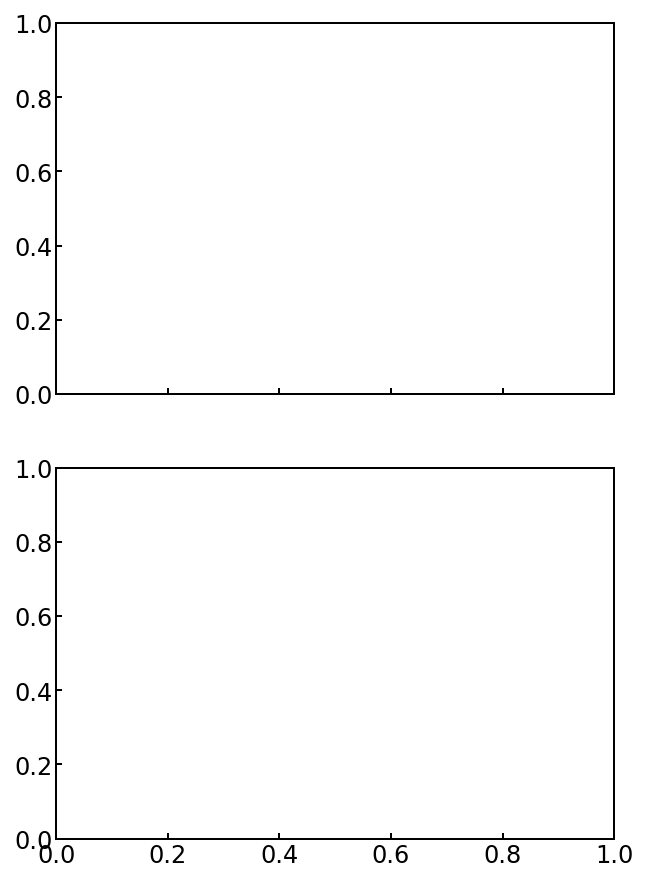

In [9]:
#################################
# Test-specific keys
#################################
var_0_key = {"0":"Surface Off","1":"Surface On"}

#################################
# Simulation parameters
#################################
d = 2 #System dimensions
R = 1 #drop radius
w = (2*R)**2 #product of the original semi-axis lengths

h3 = 3.5 #Smoothing length coefficient

eta = 0.0 #dynamic viscosity
rho0 = 1 #initial density
nu = eta/rho0 #kinetic viscosity

sigma0 = 0.0714 #Decay timescale

#################################
# Plot parameters
#################################
fig, ax= plt.subplots(2,1,figsize=(10,15),sharex=True)


#################################
# Benchmark
#################################
filepath = '/home/epalermo/dev/test/droplet_extension/test_data_files/ncdf'
data_files = (generate_file_names(filepath))

all_run_info = []

for run in data_files:
    #Gather run info from the file name
    run_info, ds, sf, mp, N = gather_run_info(run,data_files)

    #Extract position and velocity data from ds
    td,xd,yd,vxd,vyd = extract_velocity_data(ds)

    #Major axis length and kinetic energy
    init_conditions = [R*2, sigma0]
    a_data = np.max(xd, axis=1) #major axis length
    KE_data = calc_KE(td,xd,yd,vxd,vyd,mp)

    #Only plot runs for a specific sf
    #sf_plot = 0.1    
    #if sf == sf_plot:
    plot_profile(td*sigma0/R,a_data/a_data[0],run_info, ax[0], "data",plot_key)
    plot_profile(td*sigma0/R, KE_data/KE_data[0],run_info, ax[1], "data",plot_key)


#Calculate and plot analytical solution
a_ref, KE_ref = analyt_soltn_values(td, init_conditions, mp)
plot_profile(td*sigma0/R,a_ref/a_ref[0],run_info, ax[0], "analytic",plot_key)
plot_profile(td*sigma0/R, KE_ref/KE_ref[0],run_info, ax[1], "analytic",plot_key)

#################################
# Plot format
#################################
axis_plot_params = [r"$\frac{t\sigma_0}{R}$",r"$\frac{a}{a_0}$",
                  None,None,
                  "lower right"]
KE_plot_params = [r"$\frac{t\sigma_0}{R}$",r"$\frac{E_k}{E_{k0}}$",
                  None,None,
                  "lower left"]
format_plot(fig, ax,[axis_plot_params,KE_plot_params])

## Velocity Gradient Convergence <a class="anchor" id="gradv_funcs"></a>

In [ ]:
#Analytically obtained gradient
def ref_gradv(x,y):
    #gradient = u_0*k_x*np.cos(k_x*x)
    gradient = 0
    return gradient


def data_gradv(ds):
    atom_values = {}
    frame = -1
    atom_ids = (ds["id"][frame])
    for atom in atom_ids:
        coords = (ds["coordinates"][frame,atom-1,0:2]) #coords
        x = coords[0]
        y = coords[1]
        
        grad_v = (ds["f_rheo_grad_gradv"][frame,atom-1,:])[0] #grad v
        
        atom_values[(x,y)] = grad_v

    return atom_values


#Benchmark by plotting kinetic energy decay and viscosity
def gradv_benchmark(data_files, ax):
    ax = ax
    all_run_info = []

    for run in data_files:
        #Gather run info from the file name
        run_info, ds, sf, mp, N = gather_run_info(run,data_files)
        
        #Calculate divergence from data and error wrt analytical gradient
        atom_values = data_gradv(ds)
        error = []
        for item in atom_values.items():
            ref_gradient = ref_gradv(item[0][0],item[0][1])
            particle_error = np.abs(ref_gradient-item[1])
            error.append(particle_error)
        L_1_norm = np.sum(error)/len(atom_values)
        run_info.append(L_1_norm)
        all_run_info.append(run_info)
    
    #Convert run_info to dataframe for plotting
    plot_normalized_error(all_run_info)
    

In [ ]:
#################################
# Test-specific keys
#################################

#################################
# Simulation parameters
#################################

#System dimensions
d = 2

#Smoothing length coefficient
h3 = 3.5

#System size
L_x = 10 #Size of the system
L_y = L_x

#Fluid properties
eta = 0.01
rho0 = 1
nu = eta/rho0

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y

#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)


#################################
# Plot parameters
#################################

fig_gradv, ax_gradv = plt.subplots(1,1,figsize=(10,10))


#################################
# Benchmark
#################################

filepath = '/home/epalermo/dev/test/kernel_convergence/gradv_convergence/data_files_current'
gradv_benchmark(generate_file_names(filepath),ax_gradv)

#################################
# Plot format
#################################
gradv_plot_params = [r"$\frac{L}{\Delta x}$",r"$\frac{L_1}{N}$",
                     None,None,
                     "lower left"]
format_plot(fig_gradv, ax_gradv,[gradv_plot_params])

## Surface Normal Convergence<a class="anchor" id="surf_funcs"></a>

In [ ]:
#Calculate the analytically determined surface normal as a function of x and y
def calc_ref_normal(x,y,geometry):
    if geometry == "circle":
        n_x = x/np.sqrt(x**2+y**2)
        n_y = y/np.sqrt(x**2+y**2)
    if geometry == "sine":
        n_x = -np.cos(x)/np.sqrt(np.cos(x)**2+1)
        n_y = 1/np.sqrt(np.cos(x)**2+1)
    
    return np.array([n_x, n_y])


#Extract data for the surface normal from LAMMPS simulation
def calc_data_normal(ds, geometry):
    atom_values = {}
    frame = -1
    atom_ids = (ds["id"][frame])
    for atom in atom_ids:
        if geometry == "circle":
            if ds["c_surf"][frame][atom-1] == 2.: 
                coords = (ds["coordinates"][frame,atom-1,0:2]) #coords
                x = coords[0]
                y = coords[1]

                n_x, n_y = (ds["f_2"][frame,atom-1,:])

                atom_values[(x,y)] = np.array([n_x,n_y])

    return atom_values


def surf_benchmark(data_files, ax, geometry):
    ax = ax
    all_run_info = []

    for run in data_files:
        #Gather run info from the file name
        run_info, ds, sf, mp, N = gather_run_info(run,data_files)
        
        #Return surface normal as a function of atom coordinates (for surface atoms only)
        atom_values = calc_data_normal(ds, geometry)
        #Calculate error wrt geometrically calculated normal
        error = []
        for item in atom_values.items():
            ref_normal = calc_ref_normal(item[0][0],item[0][1], geometry)
            err_vector = ref_normal-item[1]
            err_vector_mag = np.sqrt(err_vector.dot(err_vector))
            error.append(err_vector_mag)
        L_1_norm = np.sum(error)/len(atom_values)
        run_info.append(L_1_norm)
        all_run_info.append(run_info)
    
    #Convert run_info to dataframe for plotting
    plot_normalized_error(all_run_info)

In [ ]:
var_0_key = {"0":"Shifting Off","1":"Shifting On"} #Viscosity calc method
var_1_key = {"5":"Quintic","0":"CRK0", "1":"CRK1", "2":"CRK2"}


#---System Properties---#

d = 2 #System dimensions
r = 5 #drop radius
h3 = 3.5 #Smoothing length coefficient

eta = 0.01 #dynamic viscosity
rho0 = 1 #initial density
nu = eta/rho0 #kinetic viscosity

fig_surf, ax_surf = plt.subplots(1,1,figsize=(10,10))

filepath = '/home/epalermo/dev/test/kernel_convergence/normal_convergence/circle_surface/data_files/'
surf_benchmark(generate_file_names(filepath),ax_surf,"circle")

###Plot Format###
surf_plot_params = [r"$\frac{L}{\Delta x}$",r"$\frac{L_1}{N}$",
                     None,None,
                     "lower left"]
format_plot(fig_surf, ax_surf,[surf_plot_params])


## Dam Break 

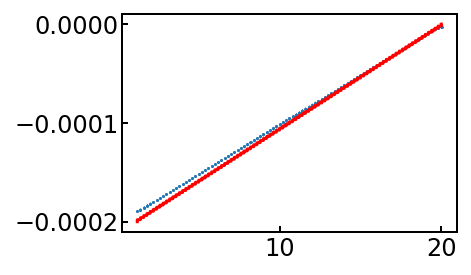

In [19]:
rho0=1

pwd = os.getcwd()
filepath = "/home/epalermo/test/rheo_bench/old_dam_break/static/ncdf/0_10_dr0p1_static.nc"
ds = Dataset(filepath)
fluid_ids = []
frame = -1
atom_ids = ds["id"][frame]
for count,atom in enumerate(atom_ids):
    if ds["type"][frame,count] == 1:
        fluid_ids.append(atom)
fluid_min = np.min(fluid_ids)
fluid_max = np.max(fluid_ids) 

rho = ds["c_den"][frame,fluid_min:fluid_max] #this only works because fluid atoms are consecutive, would NOT work if type changes during simulation
p = 1**2*(rho-rho0) #cs = 1
y = ds["coordinates"][frame,fluid_min:fluid_max,1]
plt.scatter(y,p,s=0.5)


p_static = rho0 * 1e-5 * np.max(y)
p_ref = np.linspace(-p_static,0,len(y))

plt.plot(y,p_ref,color="red")

numpy.int32